In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge/jupyter notebooks
Current path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge


In [2]:
import torch
import monai
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from Data_Modules.MONAI_Dict_Dataset_Module import MONAI_CSV_Scrolls_Dataset
import matplotlib.patches as patches
from lit_models.UNET_monai_lit import UNET_lit
from monai.visualize import matshow3d
import einops

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")


2023-05-01 21:43:32,114 - Created a temporary directory at /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmpmz1vy70o
2023-05-01 21:43:32,114 - Writing /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmpmz1vy70o/_remote_module_non_scriptable.py


In [3]:
KAGGLE_DIR = PATH / "kaggle"

INPUT_DIR = KAGGLE_DIR / "input"

COMPETITION_DATA_DIR = INPUT_DIR / "vesuvius-challenge-ink-detection"

TRAIN_DATA_CSV_PATH = COMPETITION_DATA_DIR / "data_train_0.5.csv"
TEST_DATA_CSV_PATH = COMPETITION_DATA_DIR / "data_test_1.0.csv"


In [4]:
# Initiating Dataset with parameters

# buffer =   -- x,y patchsize for training
# z_start =  --  Offset of slices in the z direction
# z_dim =    -- Number of slices in the z direction. Max value is (64 - z_start)
# validation_rect =  -- rectangle removed for validation set
# shared_height = -- Height to resize all scrolls
# scroll_fragments = -- scrolls to be used 

dataset = MONAI_CSV_Scrolls_Dataset(
                 batch_size=1,
    data_csv_path=TRAIN_DATA_CSV_PATH,
    num_workers=0,
    num_samples=16,
    patch_size=(224,224),
    val_fragment_id=1,
)


In [5]:
# prepeare data, by processng images and loading dataloader

dataset.setup()

# train: 2
# val: 1


In [6]:
#lit_model = UNET_lit(z_dim = dataset.z_dim)

trainer = pl.Trainer(
        accelerator='mps',
        benchmark=True,
        max_epochs=20,
        check_val_every_n_epoch= 1,
        devices=1,
        #fast_dev_run=fast_dev_run,
        logger=pl.loggers.CSVLogger(save_dir='logs/'),
        log_every_n_steps=1,
        
        overfit_batches=0,
        precision=16,
         accumulate_grad_batches=8,)

trainer.fit(lit_model, datamodule=dataset)

In [7]:
def visualize_dataloaders(dataloaders, train=True):
    for stage, dataloader in dataloaders.items():
        for batch_idx, batch in enumerate(dataloader):
            volumes = batch["volume_npy"]
            masks = batch["mask_npy"]
            
            if train:
                labels = batch["label_npy"]
            else: 
                labels = masks
            out = [volumes, masks, labels]
            for volume, mask, label in zip(volumes, masks, labels):
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                plt.suptitle(f"stage: {stage}, fragment: {batch_idx}")

                for idx, image in enumerate((volume, mask, label)):
                    matshow3d(
                        volume=image,
                        fig=axes[idx],
                        title=f"{list(image.shape)}, {image.min().item()}, {image.max().item()}",
                        vmin=0.0,
                        vmax=1.0,
                        every_n=2,
                        fill_value=1.0,
                        margin=4,
                        cmap="gray",
                    )
            return out

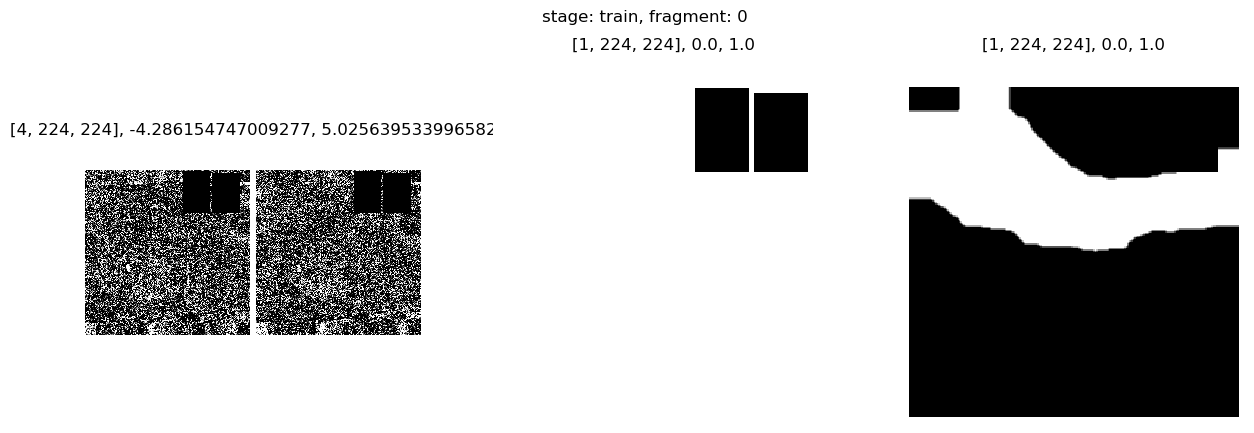

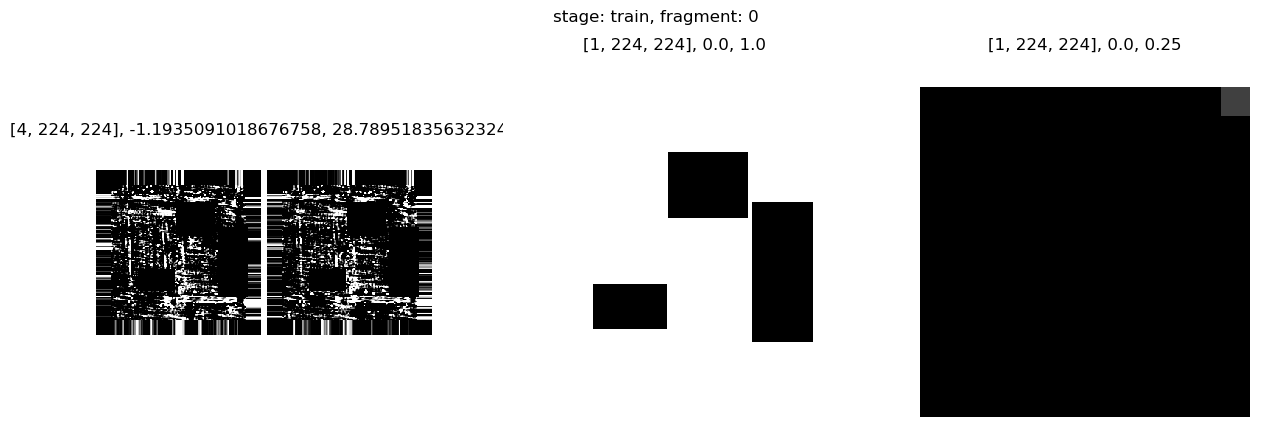

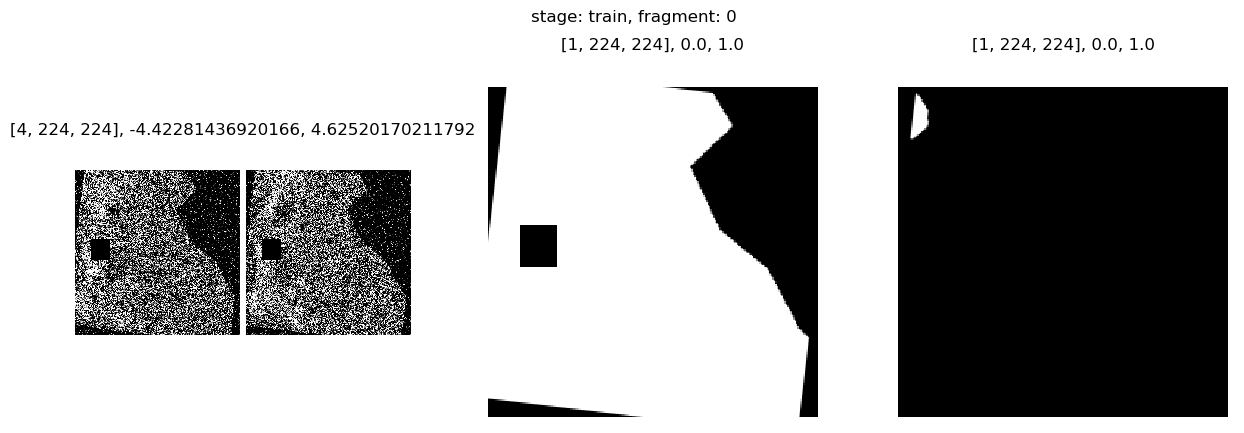

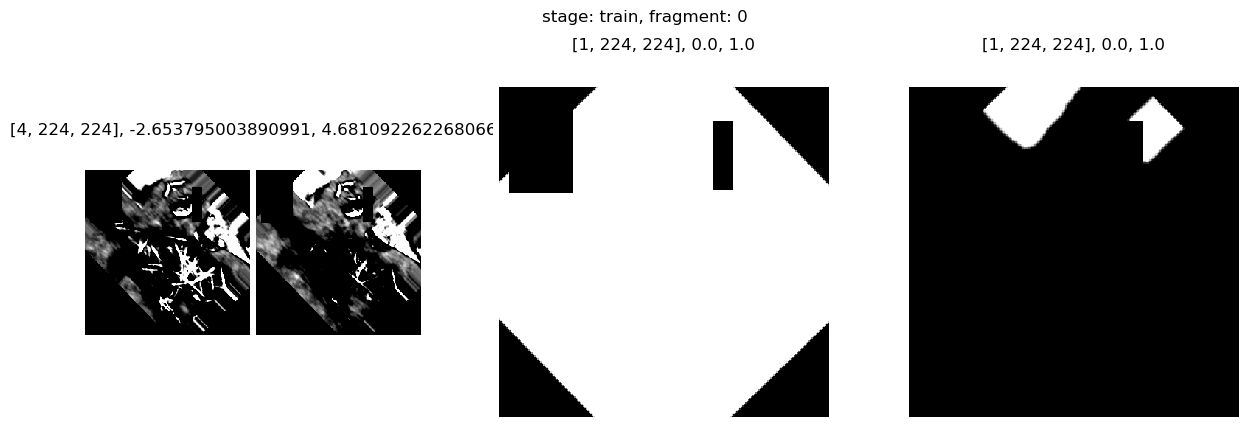

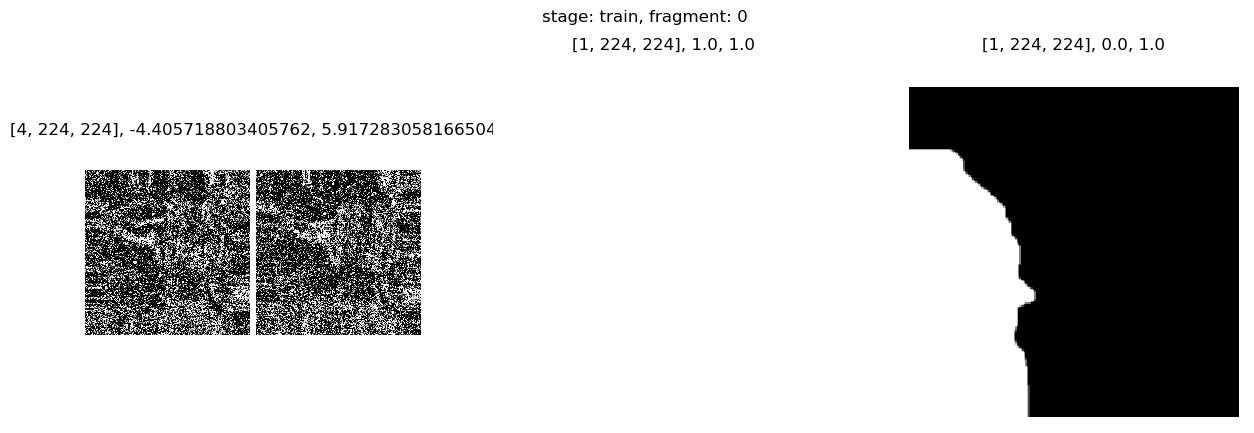

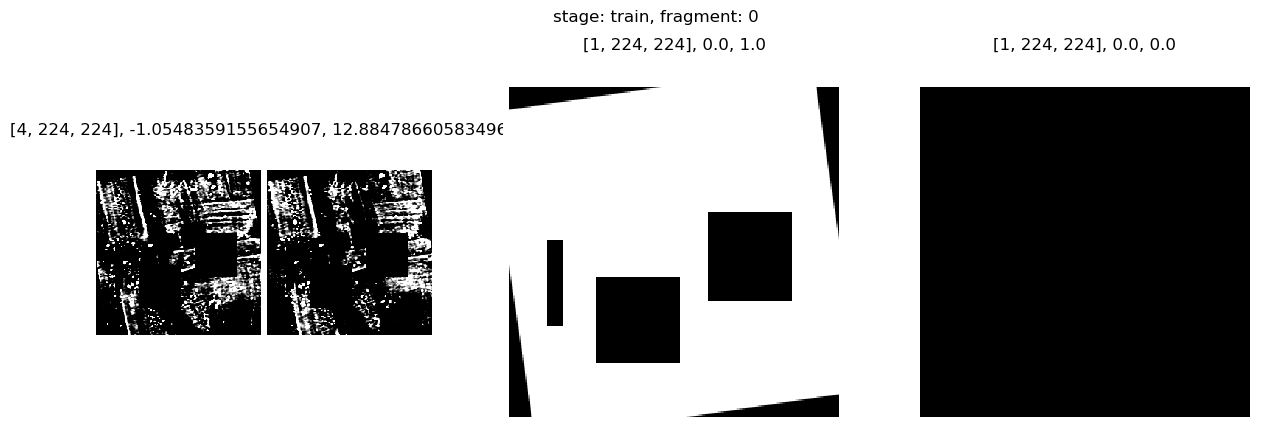

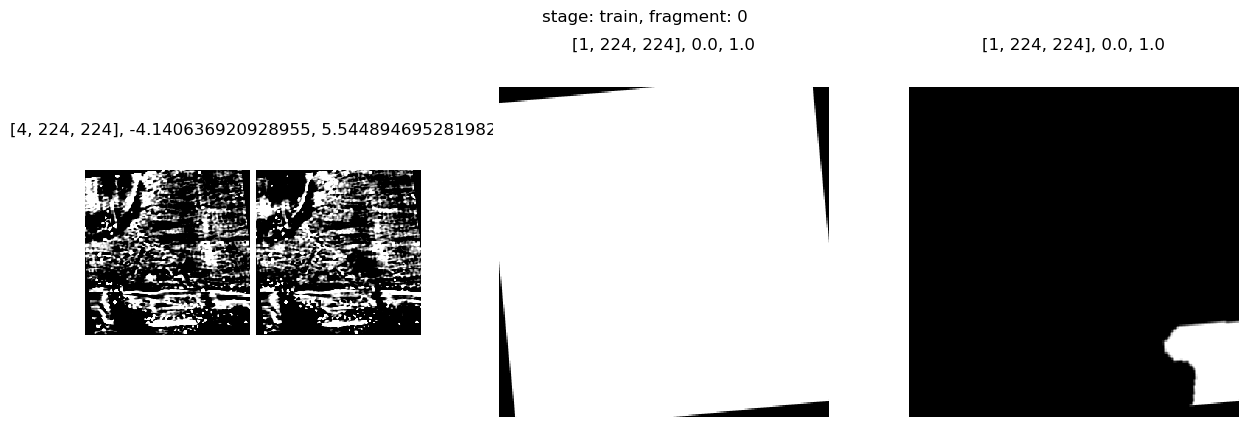

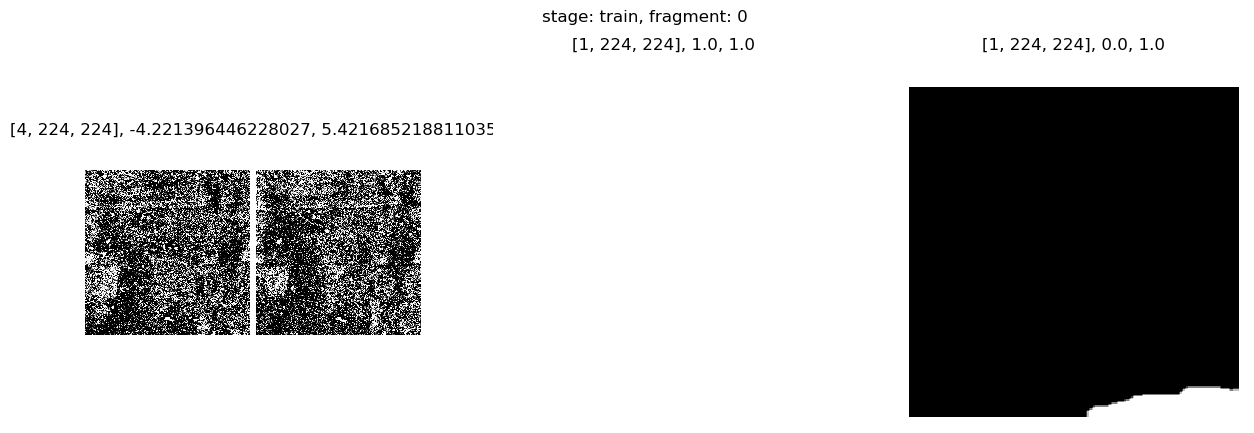

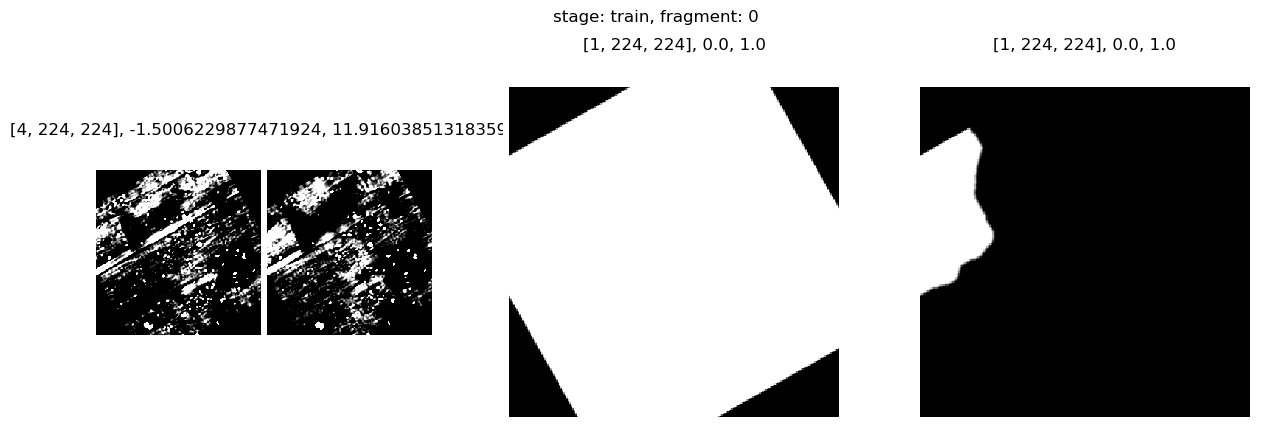

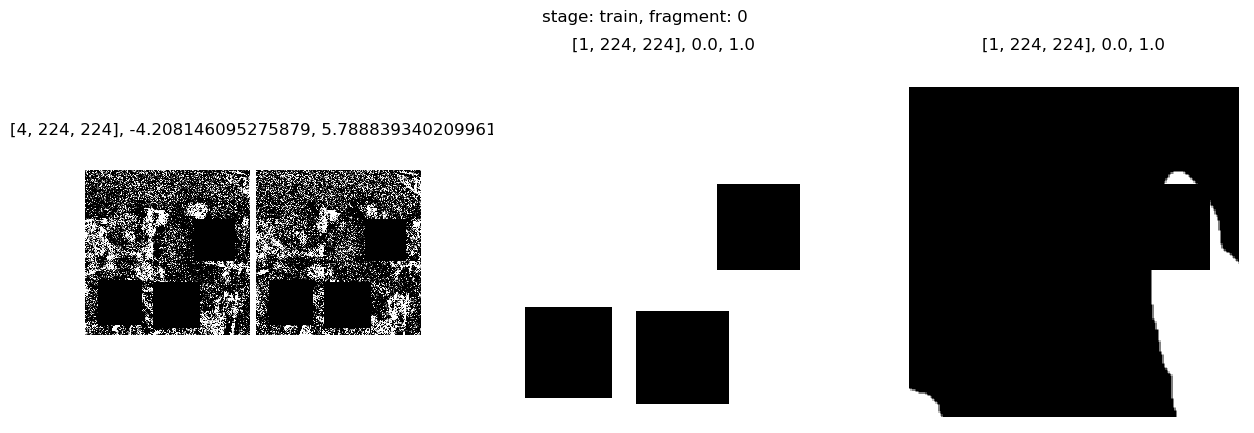

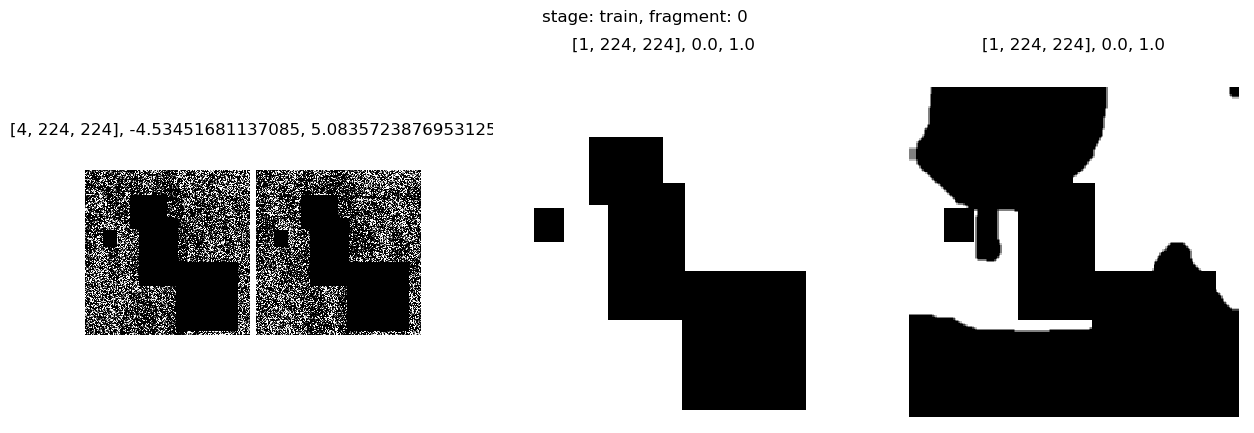

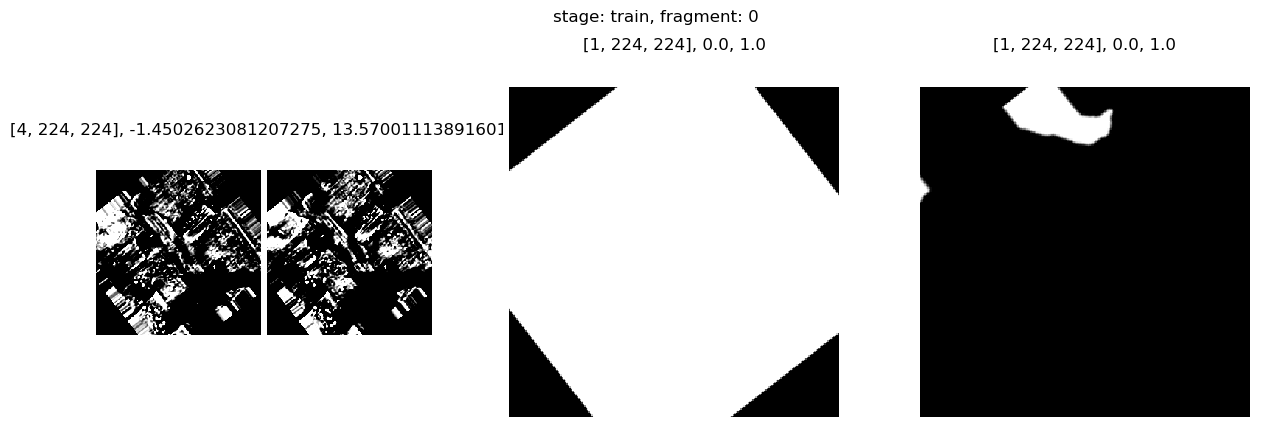

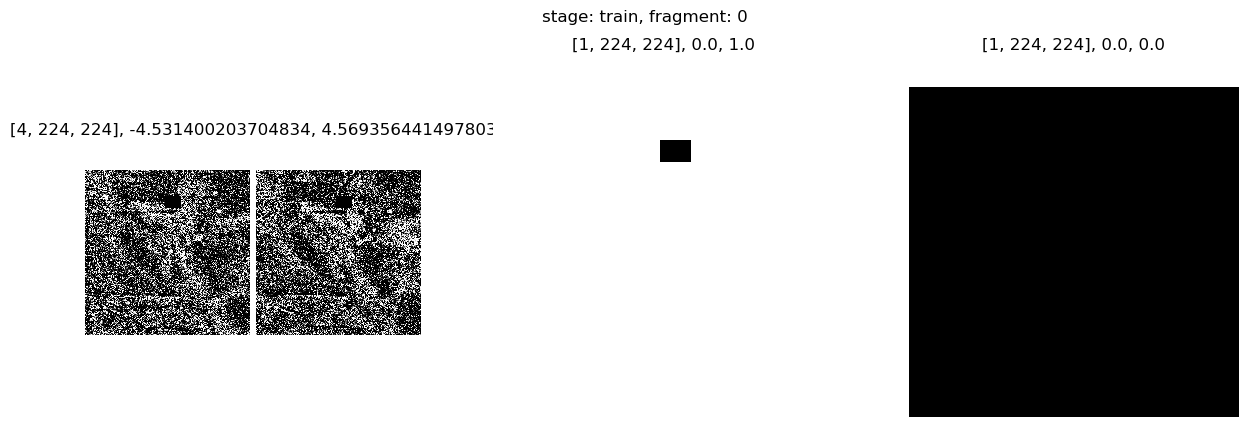

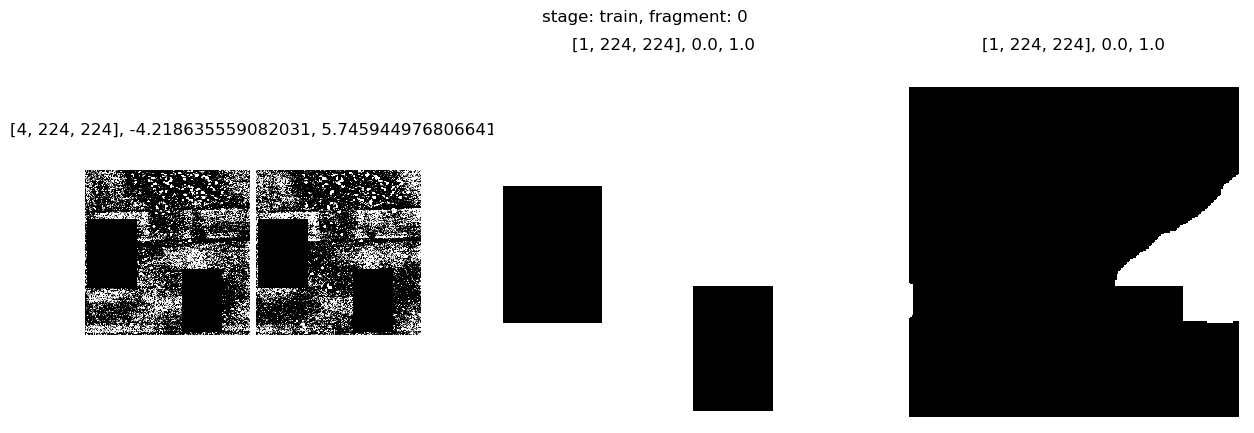

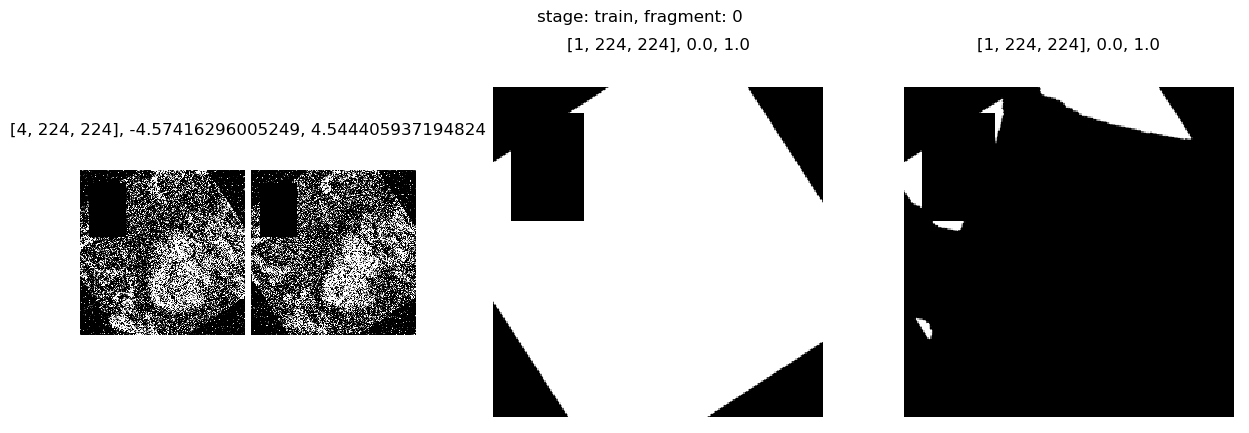

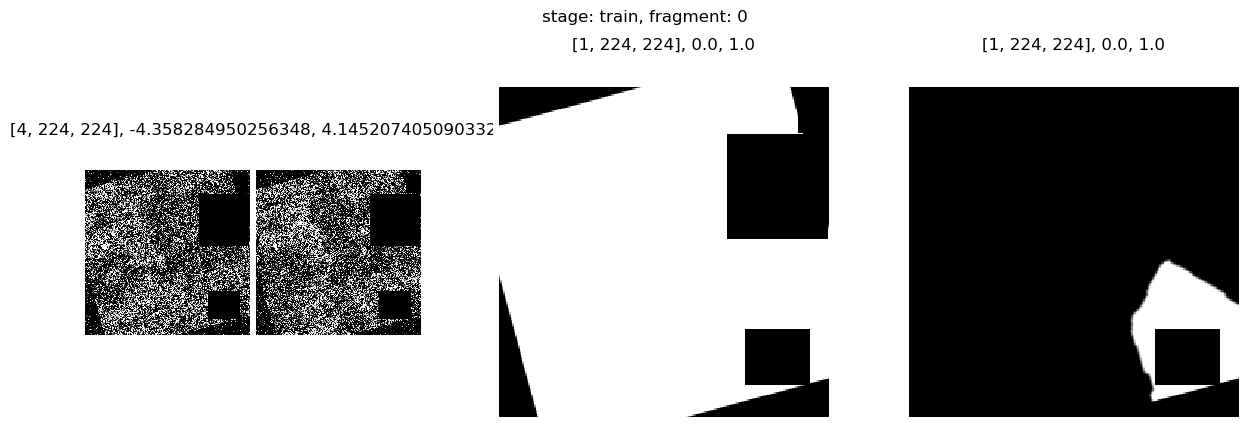

In [8]:
dataloaders = {
    "train": dataset.train_dataloader(),
    "val": dataset.val_dataloader(),
}

batch = visualize_dataloaders(dataloaders)

In [9]:
volumes, masks, labels = batch[0], batch[1], batch[2]

In [10]:
print(volumes.shape, masks.shape, labels.shape)

torch.Size([16, 4, 224, 224]) torch.Size([16, 1, 224, 224]) torch.Size([16, 1, 224, 224])


In [11]:
import segmentation_models_pytorch as smp
import ssl

backbone = 'se_resnext50_32x4d'
ssl._create_default_https_context = ssl._create_unverified_context
model = smp.Unet(
            encoder_name='se_resnext50_32x4d', 
            encoder_weights='imagenet',
            in_channels=4,
            classes=1,
            activation=None,
        )

model_2 = monai.networks.nets.UNet(
                spatial_dims=2,
                in_channels=4, #z_dim
                out_channels=1,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
                dropout=0,
                norm = 'batch',
            )

In [12]:
model_2

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convol

In [13]:
out = model_2(volumes)

In [14]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
loss = monai.losses.DiceLoss(sigmoid=True)
loss_dice = monai.losses.MaskedLoss(loss)
bce = torch.nn.BCEWithLogitsLoss()
bce_w_weights = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor(5))

In [15]:
bce_w_weights(out, labels)

tensor(1.1286, grad_fn=<AliasBackward0>)

In [16]:
bce(out,labels)

tensor(0.9102, grad_fn=<AliasBackward0>)

In [17]:


DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
focal_loss = smp.losses.FocalLoss(mode = 'binary', 
                                  alpha=.25,
                                  gamma=2.0, 
                                  ignore_index=None, 
                                  reduction='mean', 
                                  normalized=False, 
                                  reduced_threshold=None)

TverskyLoss = smp.losses.TverskyLoss(
                    mode='binary', 
                    log_loss=False, 
                    alpha=.5, 
                    beta=.5)

loss = monai.losses.DiceLoss(sigmoid=True)
maksed_dice_loss = monai.losses.MaskedLoss(loss)

loss_fo = monai.losses.DiceFocalLoss(
                                            include_background=True,
                                            sigmoid=True,
                                            #other_act = torch.nn.ReLU(),
                                            batch = True,
                                            focal_weight = .2,
                                            #reduction = 'none',
                                            )

In [18]:
fake_label = torch.zeros(1,1,64,64)
fake_label[0, :, 20:40]=1
fake_label[:,:,:, 20:40]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [19]:
fake_image = torch.zeros(1,1,64,64)
fake_image[0, :, 20:30]=0
fake_image[0, :, 44:54]=1
#fake_image[:,:,:, 0:20]

In [20]:
loss_fo(out, labels)

tensor(0.9226, grad_fn=<AliasBackward0>)

In [21]:
labels_sample = torch.ones(1,1,64,64)
labels_sample

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

In [22]:
focal_loss(out*masks, labels)

tensor(0.2627, grad_fn=<AliasBackward0>)

In [23]:
DiceLoss(out, labels)

tensor(0.8438, grad_fn=<AliasBackward0>)

In [24]:
BCELoss(out, labels)

tensor(0.9102, grad_fn=<AliasBackward0>)

In [25]:
maksed_dice_loss(out, labels, masks)

tensor(0.8630, grad_fn=<AliasBackward0>)

In [26]:
def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    #return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

In [27]:
losses = criterion(out, labels)

In [28]:
losses.item()

0.8769676685333252

In [29]:
tp, fp, fn, tn = smp.metrics.get_stats(out, labels.long(), mode='binary', threshold=0.5)


accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
fbeta = smp.metrics.fbeta_score(tp, fp, fn, tn, beta = .5, reduction ='micro-imagewise')
precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise")

In [30]:
precision

tensor(0.0881)

In [31]:
accuracy.item()

0.6555674076080322

In [32]:
recall

tensor(0.4341)

In [33]:
fbeta

tensor(0.0947)

In [34]:
model_unetr = monai.networks.nets.UNETR(in_channels = 4 , #z_dim 
                                       out_channels = 1, 
                                       img_size = (224,224) , 
                                       feature_size=16,
                                       hidden_size=768, 
                                       mlp_dim=3072, 
                                       num_heads=12, 
                                       pos_embed='conv', 
                                       norm_name='instance', #'batch'
                                       conv_block=True, 
                                       res_block=True, 
                                       dropout_rate=0.0, 
                                       spatial_dims=2, 
                                       qkv_bias=False,
                                        
                                      )

In [35]:
output=model_unetr(volumes)

In [36]:
output.shape

torch.Size([16, 1, 224, 224])

In [37]:
mask1 = pd.read_csv()

NameError: name 'pd' is not defined

In [ ]:
len(dataset.train_pixels)

In [ ]:
model = monai.networks.nets.UNet(
                spatial_dims=2,
                in_channels=16, #z_dim
                out_channels=1,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
                dropout=.2,
            )

In [ ]:
dataloader = iter(dataset.train_dataloader())
train_tensor = None
train_label = None
train_mask = None
for i in range(1):
    # Get image and label from train data -- change number for different ones
    #print(next(dataloader))
    subvolume, inklabel, mask = next(dataloader)
    print('subvolume shape:',subvolume.shape)
    print('inklabel shape:',inklabel.shape)
    print('mask shape', mask.shape)
    train_tensor = subvolume
    train_label = inklabel
    train_mask = mask

In [ ]:
train_tensor.squeeze(1).shape

### MONAI Dataloader Work

In [ ]:
from monai.data import ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter, DataLoader
from monai.data import DataLoader
from monai.transforms import (
    Compose,
    LoadImage,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import first

In [ ]:


array_ds = monai.data.ArrayDataset(img= dataset.image_tensors.unsqueeze(0), 
                                   #img_transform = transform,
                                   seg=dataset.mask.unsqueeze(0).unsqueeze(0),
                                   #seg_transform = transform,
                                   #label_transform =transform,
                                   labels = dataset.label_tensors.unsqueeze(0).unsqueeze(0) 
                                  )

patch_iter = monai.data.PatchIter(patch_size=( 512, 512))

def img_seg_iter(x):
    for im, seg, label in zip(patch_iter(x[0]), patch_iter(x[1]),patch_iter(x[2]) ):
        # uncomment this to confirm the coordinates
        #print("coord img:", im[1].flatten(), "coord seg:", seg[1].flatten())
        yield ((im[0], seg[0], label[0]),)
        
patched_ds = monai.data.GridPatchDataset(array_ds, patch_iter = img_seg_iter, with_coordinates=False)



In [ ]:
monai_dataloader = DataLoader(
            patched_ds,
            batch_size=2,
            #shuffle=True,
            num_workers=0,
        )
volumes_tensor = None
masks_tensor = None
labels_tensor = None
for batch_idx, batch in enumerate(monai_dataloader):
    if batch_idx>20:
        break
    volumes, masks, labels = batch
    print(volumes.shape, masks.shape, labels.shape)
    volumes_tensor, masks_tensor, labels_tensor =  volumes, masks, labels 
    for volume, mask , label in zip(volumes, masks, labels):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        plt.suptitle(f"batch: {batch_idx}") 
        
        for idx, image in enumerate((volume, mask, label)):
            matshow3d(
                volume=image,
                fig=axes[idx],
                title=f"{list(image.shape)}, {image.min().item()}, {image.max().item()}",
                vmin=0.0,
                vmax=1.0,
                every_n=2,
                fill_value=1.0,
                margin=4,
                cmap="gray",
            )


In [ ]:
print(volumes_tensor.shape, masks_tensor.shape, labels_tensor.shape )

In [ ]:
model_unetr = monai.networks.nets.UNETR(in_channels = 2 , #z_dim 
                                       out_channels = 1, 
                                       img_size = (512,512) , 
                                       feature_size=16,
                                       hidden_size=768, 
                                       mlp_dim=3072, 
                                       num_heads=12, 
                                       pos_embed='conv', 
                                       norm_name='instance', 
                                       conv_block=True, 
                                       res_block=True, 
                                       dropout_rate=0.0, 
                                       spatial_dims=2, 
                                       qkv_bias=False,
                                        
                                      )

In [ ]:
model = monai.networks.nets.UNet(
                spatial_dims=2,
                in_channels=2, #z_dim
                out_channels=1,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
                dropout=.2,
            )

In [ ]:
labels_tensor.shape

In [ ]:
res = model(volumes_tensor)
print(res.shape)
loss = monai.losses.DiceLoss(sigmoid=True)
loss = monai.losses.MaskedLoss(loss)
value = loss(res, labels_tensor, masks_tensor)


In [ ]:
pred = torch.sigmoid(res.detach()).gt(.4).int()

In [ ]:
accuracy = (pred == labels_tensor).sum().float().div(labels_tensor.size(0)*labels_tensor.size(2)**2)

In [ ]:
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

In [ ]:
fbeta = fbeta_score( torch.sigmoid(res), labels_tensor, .4)

In [ ]:
fbeta

In [ ]:
from torchmetrics import FBetaScore
fbeta_torch = FBetaScore( task="binary", beta=.5, threshold=.4)
fbeta_from_torch = fbeta_torch(torch.sigmoid(res), labels_tensor)
print(fbeta_from_torch)

In [ ]:
monai_dataloader_val = DataLoader(
            array_ds,
            batch_size=2,
            #shuffle=True,
            num_workers=0,
        )

In [ ]:
for batch_idx, batch in enumerate(monai_dataloader_val):
    if batch_idx>3:
        break
    volumes, masks, labels = batch
    print(volumes.shape, masks.shape, labels.shape)

## Experiments with patching


In [ ]:
BUFFER = 256
import random


fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15,5))
ax1.imshow(dataset.label_tensors)
for i in range(50):
    y,x = random.randint(0,8000), random.randint(0,5000)
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=1, edgecolor='r', facecolor='none')
    ax1.add_patch(patch)

ax2.imshow(dataset.mask)

plt.show()

In [ ]:
def threshold_at_one(x):
    # threshold at 1
    return x > 0

transorm_test = monai.transforms.Compose(
            [
              
      monai.transforms.RandFlip(
                   
                    prob=0.5,
                    spatial_axis=0,
                ),
                monai.transforms.RandFlip(
                    prob=0.5,
                    spatial_axis=1,
                ),
            ]
        )


array_ds_test = monai.data.ArrayDataset(img= dataset.label_tensors.unsqueeze(0).unsqueeze(0),
                                   #img_transform = transorm_test,
                                   seg=dataset.mask.unsqueeze(0).unsqueeze(0),
                                   #seg_transform = transorm_test,
                                   #label_transform =transform,
                                   #labels = dataset.label_tensors.unsqueeze(0).unsqueeze(0) 
                                  )

new_ds = monai.data.Dataset(array_ds_test, )

In [ ]:
new_ds.data[0][0].shape

In [ ]:
dataset.mask.unsqueeze(0).unsqueeze(0).shape

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(new_ds.data[0][0].squeeze(0))
ax2.imshow(new_ds.data[0][1].squeeze(0))
plt.show()

In [ ]:
from Data_Modules.MONAI_dataset import MONAI_Scrolls_Dataset

dataset_monai = MONAI_Scrolls_Dataset(
                
    
                patch_size = 128,
                 z_start = 12,
                 z_dim = 2,
                 validation_rect = (1100, 3500, 700, 950),
                shared_height = 5000,
                 downsampling =None,
                 train_scroll_fragments = [1,2],
                 val_scroll_fragments = [3],
                 stage = 'train',
                 batch_size=2,
                 num_workers =8 ,
                          
                         )

dataset_monai.prepare_data()

In [ ]:
print(dataset_monai.tensors['image'].shape, )
print(dataset_monai.tensors['label'].shape, )
print(dataset_monai.tensors['mask'].shape, )

In [ ]:
keyes = ('image','label', 'mask')

transorm_test = monai.transforms.Compose(
            [
              
     monai.transforms.RandFlipd(
                    keys=keyes,
                    prob=.5,
                    spatial_axis=0,
                ),
        monai.transforms.RandFlipd(
                    keys=keyes,
                    prob=.5,
                    spatial_axis=1,
                ),
            ]
            
        )


array_ds_test = monai.data.Dataset(data= dataset_monai.tensors,
                                   transform = transorm_test,
                                   #seg=dataset.mask.unsqueeze(0).unsqueeze(0),
                                   #seg_transform = transorm_test,
                                   #label_transform =transform,
                                   #labels = dataset.label_tensors.unsqueeze(0).unsqueeze(0) 
                                  )

#new_ds = monai.data.Dataset(array_ds_test, )

In [ ]:
array_ds_test.data['label'].shape

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(array_ds_test.data['label'].squeeze(0).squeeze(0))
ax2.imshow(array_ds_test.data['mask'].squeeze(0).squeeze(0))
plt.show()

In [ ]:
dataset.label_tensors

In [ ]:
fig, ax = plt.subplots()
ax.imshow(dataset.label_tensors)

BUFFER = 256

patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(patch)

In [ ]:
x,y = y,x
BUFFER = 256
print(y,x)

In [ ]:
image = dataset.image_tensors[:, y - BUFFER:y + BUFFER , x - BUFFER:x + BUFFER ].view(1, 8, BUFFER * 2 ,BUFFER * 2)





In [ ]:
label =dataset.label_tensors[ y - BUFFER:y + BUFFER  , x - BUFFER:x + BUFFER  ].view(1, BUFFER * 2 ,BUFFER * 2 )










In [ ]:
label.shape

In [ ]:
label.dtype

In [ ]:
fig, ax = plt.subplots()
ax.imshow(dataset.mask)

BUFFER = 256

patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(patch)

In [ ]:
print(dataset.mask.shape)
print(dataset.label_tensors.shape)

In [ ]:
y,x = x,y
mask = dataset.mask[ y - BUFFER:y + BUFFER  , x - BUFFER:x + BUFFER  ].view(1, BUFFER * 2 ,BUFFER * 2 )
plt.imshow(mask)

In [ ]:
plt.imshow(label)

In [ ]:
label.shape

In [ ]:
image.shape

In [ ]:
fig, ax = plt.subplots()


In [ ]:
dataset.image_tensors.shape

In [ ]:
dataset.label_tensors.shape

In [ ]:
train_tensor.shape

In [ ]:
res = model(train_tensor.squeeze(1))
print(res.shape)
print(train_label.shape)
loss = monai.losses.DiceLoss(sigmoid=True)
loss = monai.losses.MaskedLoss(loss)
value = loss(res, train_label)

In [ ]:
print(res.shape)
print(train_label.shape)

In [ ]:
loss = monai.losses.DiceLoss(sigmoid=True)
    
loss = monai.losses.MaskedLoss(loss)

In [ ]:
value = loss(res, train_label)

In [ ]:
model